In [6]:
import cv2
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt

In [7]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def round0(x):
  return round(x, 0)

def find_border_contours(gray_img):
    blur = cv2.GaussianBlur(gray_img, (5,5), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15,15))
    dilate = cv2.dilate(thresh, kernel, iterations=2)

    cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    return cnts

def show_real_only(img, prediction, min_mouth_area, max_mouth_area):
    black = cv2.resize(np.zeros_like(img), (224, 224))
    border_contours = find_border_contours(prediction)
    print(len(border_contours))
    for c in border_contours:
        x,y,w,h = cv2.boundingRect(c)
        image_ori_small = cv2.resize(img, (224, 224))
        ROI = image_ori_small[y:y+h, x:x+w]
        roi_area = ROI.shape[0]*ROI.shape[1]
        if min_mouth_area < roi_area/(image_ori_small.shape[0]*image_ori_small.shape[1]) < max_mouth_area:
          # cv2.rectangle(ROI, (0, 0), (w, h), (36,255,12), 10)
          black[y:y+h, x:x+w] = ROI
    return black

In [8]:
def show_prediction(model):
    image_ori = cv2.imread('mouth.png')
    image = np.copy(image_ori)
    image_ori1 = np.copy(image_ori)

    image.flags.writeable = False
    image = cv2.resize(image, (224, 224))
    image1 = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image1 = tf.cast(image, tf.float32) / 255.0
    prediction = np.array(tf.keras.utils.array_to_img(create_mask(model.predict(image1[tf.newaxis, ...], verbose=0))))

    min_mouth_area, max_mouth_area = 0.1, 0.9 
    black_real = show_real_only(image_ori1, prediction, min_mouth_area, max_mouth_area)
    
    return black_real

/home/kevin/dentistsmile
1


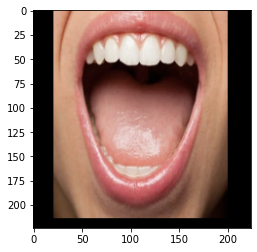

In [9]:
print(os.getcwd())
with tf.device('/cpu:0'):
    model = tf.keras.models.load_model('saved_model224/saved_model/my_model')
    plt.imshow(cv2.cvtColor(cv2.flip(show_prediction(model), 1), cv2.COLOR_BGR2RGB), cmap='brg')    
    del model
    # print(detected_key)


In [ ]:
def iodir_process_helper(input_dir, output_dir='output_', copy_input=True, segmentation_extraction_features_args=dict(), verbose=True):
    global done_count, total_count

    if not os.path.isdir(output_dir):
        os.mkdir(output_dir)
    print(f'input dir: ', input_dir)
    print(f'output dir: ', output_dir)
    
    for root, dirs, files in os.walk(input_dir, topdown=True):
        # print('file count:', len(files))
        file_count = len(files)
        done_count = file_count
        for i, file_name in enumerate(files):
            file_name:str = file_name
            input_img_path = os.path.join(root, file_name)
            output_img_dir = os.path.join(output_dir, file_name)
            if verbose:
                print(f'{i}/{file_count}: "{input_img_path}"')      
            
            segmentation_features = extract_segmentation_features(input_img_path, **segmentation_extraction_features_args)
            done_count += 1
            
            if segmentation_features is None:
                continue                  
            
            # segmentation_features = [cv2.resize(img_i, (224, 224)) for img_i in segmentation_features]

            base_file_name, extention_file_name = file_name.split('.', 1)
            if not os.path.isdir(output_img_dir):
                os.mkdir(output_img_dir)

            line_img, inpaint_mask, inpaint_thick_gray, inpaint_thick_rgb = segmentation_features
            mask_123 = replace_color(cv2.cvtColor(inpaint_thick_gray, cv2.COLOR_GRAY2RGB), (1,1,1), (1,1,1), (2,2,2))
            mask_123 = replace_color(mask_123, (255,255,255), (255,255,255), (3,3,3))
            mask_123 = replace_color(mask_123, (128,128,128), (128,128,128), (1,1,1))

            cv2.imwrite(os.path.join(output_img_dir, base_file_name+f'_line.png'), line_img)
            cv2.imwrite(os.path.join(output_img_dir, base_file_name+f'_inpaint_mask.png'), inpaint_mask)
            cv2.imwrite(os.path.join(output_img_dir, base_file_name+f'_inpaint_thick_gray.png'), inpaint_thick_gray)
            cv2.imwrite(os.path.join(output_img_dir, base_file_name+f'_inpaint_thick_rgb.png'), inpaint_thick_rgb)
            cv2.imwrite(os.path.join(output_img_dir, base_file_name+f'_mask123.png'), mask_123)

            # cv2.imwrite(os.path.join(output_dir, base_file_name+f'_filled_line.png'), filled_mask)

            if copy_input:
                with open(input_img_path, 'rb') as iip_fd:
                    with open(os.path.join(output_img_dir, file_name), 'wb+') as oop_fd:
                        oop_fd.write(iip_fd.read())

        # for name in dirs:
        #     print(os.path.join(root, name))



CLASSIFIED_TARGET_DIRS = ['Lingkar Mulut (Labeling)']
all_threads = []
for ctd in CLASSIFIED_TARGET_DIRS:
    print('dir: ', ctd)
    iohelper_kwargs = dict(input_dir=os.path.join('dentistsmile_tfds', 'dataset', ctd), output_dir='segmentation_true_mask', segmentation_extraction_features_args={
        'bg_color': [1, 1, 1], 
        'thick_line_color':[255,255,255], 
        'fill_color':[128, 128, 128],
        'line_thickness':25, 
        'raise_error': False
    })
    thread = Thread(target=iodir_process_helper, kwargs=iohelper_kwargs)
    all_threads.append(thread)
    thread.start()

for i, thread in enumerate(all_threads):
    print(f'Waiting thread {i}/{len(all_threads)} to finish')
    thread.join()

print('Done')
    
